**Ques - Image classification using GLCM-based feature extraction and traditional ML classifiers**

**Dataset Description**

BRAIN TUMOR MRI DATASET - [Dataset Link](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

**This dataset contains 7023 images of human brain MRI images which are classified into 4 classes : glioma - meningioma - no tumor and pituitary**. The images are organized into folders based on their labels and vary in size and contrast. This dataset is commonly used for brain tumor classification tasks and provides a diverse set of grayscale MRI images to train and evaluate machine learning models for both binary and multi-class classification problems.

**Load the Dataset**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Brain_Tumor_MRI_Dataset.zip to Brain_Tumor_MRI_Dataset.zip


**Unzip the Dataset**

In [2]:
import zipfile
import os

zip_path = "/content/Brain_Tumor_MRI_Dataset.zip"
extract_path = "/content/Brain_Tumor_MRI_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped!")

✅ Dataset unzipped!


**Dataset Preview : Sample Brain MRI Images**

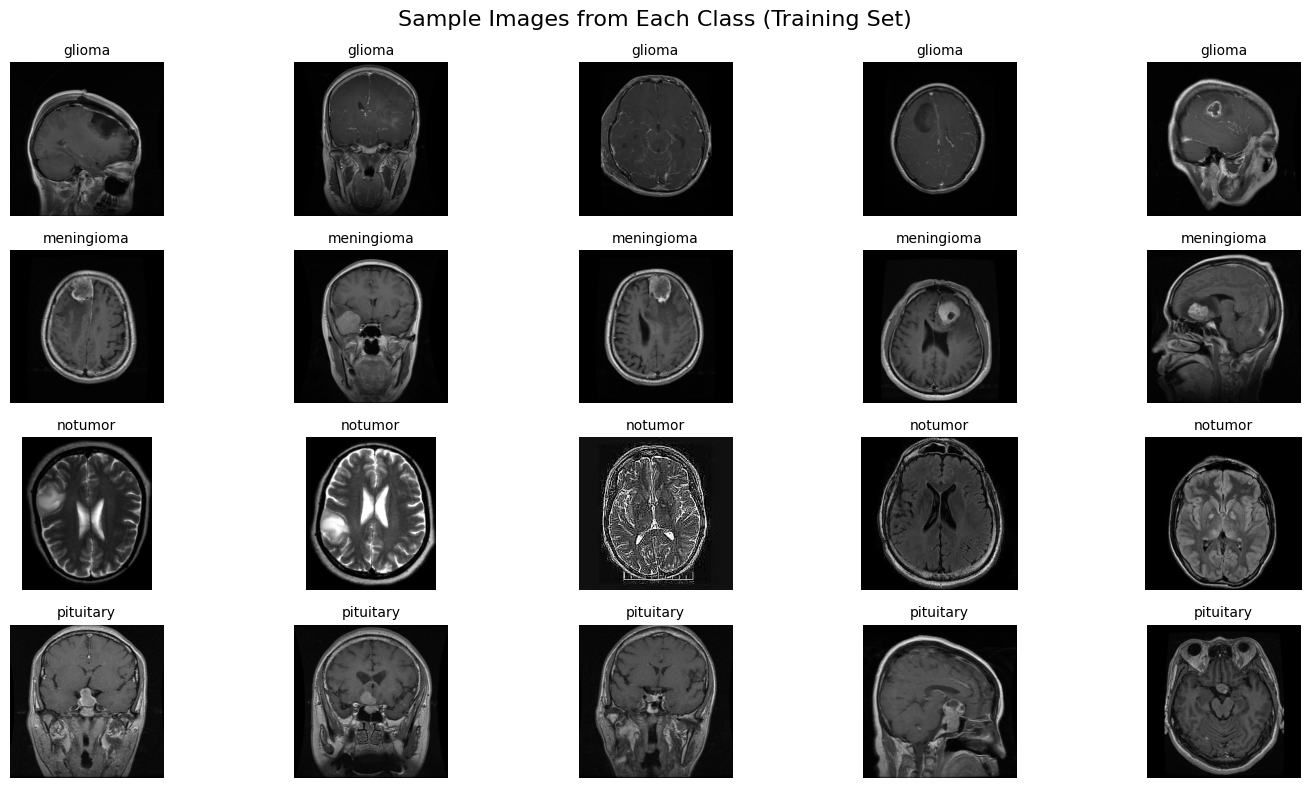

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

train_path = "/content/Brain_Tumor_MRI_Dataset/Training"
class_names = sorted([folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))])


def display_sample_images(base_path, class_list, samples_per_class=5):
    plt.figure(figsize=(15, len(class_list)*2))

    for idx, class_name in enumerate(class_list):
        class_folder = os.path.join(base_path, class_name)
        images = [img for img in os.listdir(class_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))][:samples_per_class]

        for i, img_name in enumerate(images):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(class_list), samples_per_class, idx * samples_per_class + i + 1)
            plt.imshow(img)
            plt.title(class_name, fontsize=10)
            plt.axis('off')

    plt.suptitle("Sample Images from Each Class (Training Set)", fontsize=16)
    plt.tight_layout()
    plt.show()

display_sample_images(train_path, class_names)

**Compute GLCM Features and Assign Labels (4 Classes)**

In [14]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# GLCM feature extractor function
def compute_glcm_features(img, dx=1, dy=0, levels=8):
    img = cv2.resize(img, (128, 128))  # Resize the image to 128x128
    img = (img / (256 / levels)).astype(int)

    glcm = np.zeros((levels, levels), dtype=np.float64)
    rows, cols = img.shape
    for i in range(rows - dy):
        for j in range(cols - dx):
            row_val = img[i][j]
            col_val = img[i + dy][j + dx]
            glcm[row_val][col_val] += 1

    glcm_sum = glcm.sum()
    if glcm_sum > 0:
        glcm /= glcm_sum

    # Extract features
    contrast = np.sum([(i - j) ** 2 * glcm[i, j] for i in range(levels) for j in range(levels)])
    energy = np.sum(glcm**2)
    homogeneity = np.sum([glcm[i, j] / (1 + abs(i - j)) for i in range(levels) for j in range(levels)])
    entropy = -np.sum([glcm[i, j] * np.log2(glcm[i, j] + 1e-10) for i in range(levels) for j in range(levels)])

    return [contrast, energy, homogeneity, entropy]

# Load and label images
def load_dataset(path):
    features = []
    labels = []

    class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

    for class_name in class_names:
        class_folder = os.path.join(path, class_name)
        label = class_names.index(class_name)

        for filename in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            feats = compute_glcm_features(img)
            features.append(feats)
            labels.append(label)

    return np.array(features), np.array(labels)

# Load training and testing datasets
train_path = "/content/Brain_Tumor_MRI_Dataset/Training"
test_path = "/content/Brain_Tumor_MRI_Dataset/Testing"

X_train, y_train = load_dataset(train_path)
X_test, y_test = load_dataset(test_path)

print("\nDataset Loaded!")
print(f"Training Feature Vector Shape: {X_train.shape}")
print(f"Testing Feature Vector Shape: {X_test.shape}")

# Mapping from label index to class name
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Function to print 2 samples per class
def print_samples_per_class(X, y, dataset_name):
    print(f"\nSamples from {dataset_name} Dataset:")
    printed_count = {label: 0 for label in range(4)}  # Track counts for each class

    sample_idx = 1
    for i in range(len(X)):
        label = y[i]
        if printed_count[label] < 2:
            print(f"Sample {sample_idx} - Features: {X[i]}, Label: {class_names[label]}")
            printed_count[label] += 1
            sample_idx += 1
        if all(count >= 2 for count in printed_count.values()):
            break

# Print 2 samples from each class for both training and testing datasets
print_samples_per_class(X_train, y_train, "Training")
print_samples_per_class(X_test, y_test, "Testing")

Processing notumor: 100%|██████████| 405/405 [00:09<00:00, 42.39it/s]


Dataset Loaded!
Training Feature Vector Shape: (5712, 4)
Testing Feature Vector Shape: (1311, 4)

Samples from Training Dataset:
Sample 1 - Features: [0.34215059 0.34024348 0.91662053 2.43904126], Label: glioma
Sample 2 - Features: [0.35002461 0.31732847 0.9049633  2.43056572], Label: glioma
Sample 3 - Features: [0.35863681 0.41710601 0.91405942 2.28083689], Label: meningioma
Sample 4 - Features: [0.44783465 0.30924189 0.89887324 2.70655321], Label: meningioma
Sample 5 - Features: [0.68762303 0.16307164 0.83226823 3.49232291], Label: pituitary
Sample 6 - Features: [0.54589075 0.20604035 0.85949613 3.1851831 ], Label: pituitary
Sample 7 - Features: [0.39419291 0.2389548  0.87659897 2.92753646], Label: notumor
Sample 8 - Features: [0.87573819 0.15276277 0.82790581 3.84458756], Label: notumor

Samples from Testing Dataset:
Sample 1 - Features: [0.33538386 0.37999968 0.90734498 2.49654164], Label: glioma
Sample 2 - Features: [0.31176181 0.37952264 0.91970613 2.1788083 ], Label: glioma
Sam

Trainig the classifier Logistic Regression on the dataset and classifying the testing samples among the following 4 categories i.e **'glioma', 'meningioma', 'pituitary', 'notumor'**

Epoch 0, Loss: 1.3863
Epoch 100, Loss: 1.2831
Epoch 200, Loss: 1.2320
Epoch 300, Loss: 1.1969
Epoch 400, Loss: 1.1704
Epoch 500, Loss: 1.1495
Epoch 600, Loss: 1.1323
Epoch 700, Loss: 1.1180
Epoch 800, Loss: 1.1058
Epoch 900, Loss: 1.0953
Accuracy: 51.41%


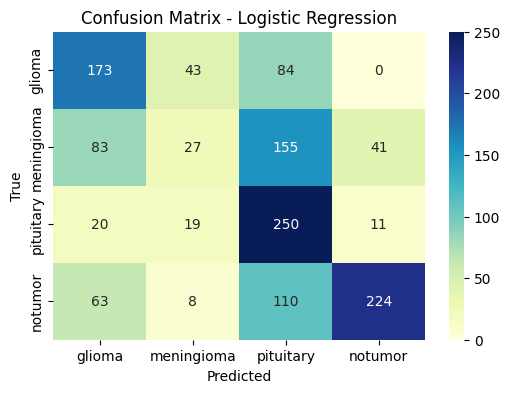

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Softmax function for multi-class classification
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Cross-entropy loss function for multi-class classification
def compute_loss(y, y_pred):
    epsilon = 1e-10  # To avoid log(0)
    return -np.mean(np.sum(y * np.log(y_pred + epsilon), axis=1))

# Training function
def train_logistic_regression(X, y, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    n_classes = y.shape[1]

    # Initialize weights and bias
    weights = np.zeros((n_features, n_classes))
    bias = np.zeros((1, n_classes))

    for epoch in range(epochs):
        # Linear combination
        linear_model = np.dot(X, weights) + bias
        # Softmax activation
        y_pred = softmax(linear_model)

        # Gradient calculations
        dw = np.dot(X.T, (y_pred - y)) / n_samples
        db = np.sum(y_pred - y, axis=0, keepdims=True) / n_samples

        # Update weights and bias
        weights -= lr * dw
        bias -= lr * db

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            loss = compute_loss(y, y_pred)
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return weights, bias

# Prediction function
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = softmax(linear_model)
    return np.argmax(y_pred, axis=1)  # Return the class with the highest probability

# Prepare dataset for training (One-hot encoding for multi-class)
def one_hot_encode(y, num_classes=4):
    return np.eye(num_classes)[y]

# Train the model
y_train_one_hot = one_hot_encode(y_train)  # One-hot encode labels for training
weights, bias = train_logistic_regression(X_train, y_train_one_hot, lr=0.05, epochs=1000)

# Predict on the test set
y_test_pred = predict(X_test, weights, bias)

# Accuracy
acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc * 100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()